# Using text to search images

In [126]:
# Imports
import os
import pandas as pd
import random
from PIL import Image
from matplotlib import pyplot as plt
import cv2
from dotenv import load_dotenv
import math
import requests
import json
import openai

In [127]:
# Configurations
target_folder = "val2017"
source_folder = "test2017"
top_n = 20

In [128]:
# Load Azure Computer Vision embeddings
azurecv_embeddings = pd.read_parquet("azurecv_image_embeddings.parquet")

In [129]:
# Function to calculate cosine similarity
def get_cosine_similarity(vector1, vector2):
    dot_product = sum(a*b for a, b in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum((val*val) for val in vector1))
    magnitude2 = math.sqrt(sum((val*val) for val in vector2))
    return dot_product / (magnitude1 * magnitude2)

## Text query

In [130]:
query = "Woman with elephant"
# query = "People crossing the street"
# query = "Detail of human face with sun glasses"
# query = "Kids playing football"

## Azure Computer Vision text embeddings

In [131]:
# Load envs
load_dotenv('.env')

# Azure Computer Vision
key = os.getenv("azure_cv_key")
endpoint = os.getenv("azure_cv_endpoint")

# Get embeddings function
def get_embedding(text):
    """
    Get embedding from text using Azure Computer Vision 4
    """
    # settings
    model = "?api-version=2023-02-01-preview&modelVersion=latest"
    url = endpoint + "/computervision/retrieval:vectorizeText" + model
    headers = {
        "Content-type": "application/json",
        "Ocp-Apim-Subscription-Key": key,
    }
    data = json.dumps({"text": query})

    # Sending the request
    r = requests.post(url, data=data, headers=headers)
    results = r.json()
    embeddings = results['vector']

    return embeddings

In [132]:
# Get source image embeddings
source_embedding = get_embedding(query)

# Calculate cosine similarity for each image
azurecv_embeddings['similarity'] = azurecv_embeddings['embedding'].apply(lambda x: get_cosine_similarity(source_embedding, x))

# Sort by similarity and select top n
top_results = azurecv_embeddings.loc[:, ['filename', 'similarity']].sort_values(by='similarity', ascending=False).head(top_n)

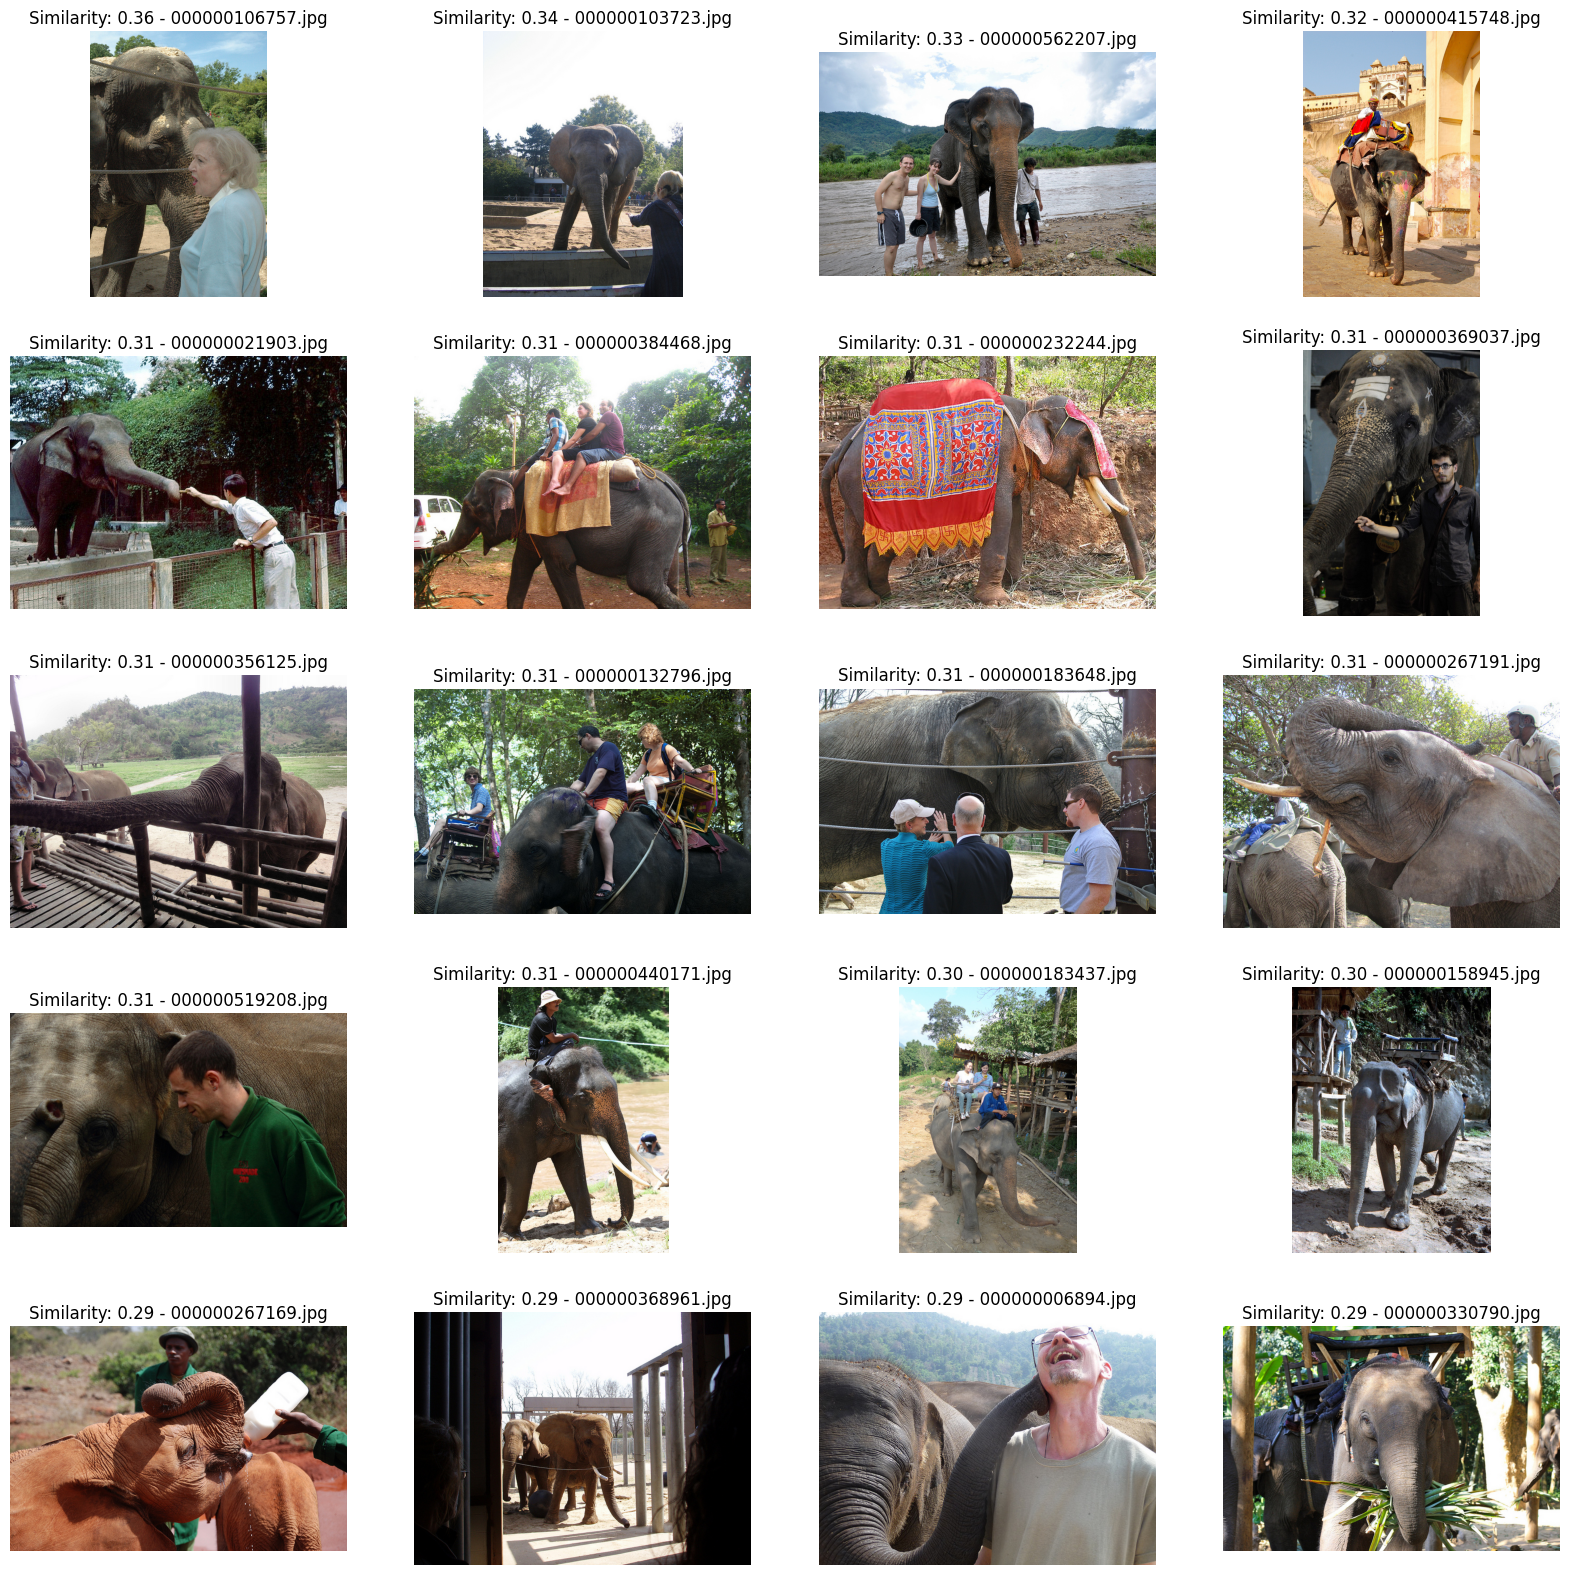

In [133]:
fig, axs = plt.subplots(5, 4, figsize=(20, 20))

# Iterate over the rows of the DataFrame
i = 0
for index, row in top_results.iterrows():
    # Load the image
    image = Image.open(f"{target_folder}/{row['filename']}")
    
    # Calculate the row and column indices
    row_index = i // 4
    col_index = i % 4
    i += 1
    
    # Display the image in the appropriate subplot
    axs[row_index, col_index].imshow(image)
    axs[row_index, col_index].axis('off')
    axs[row_index, col_index].set_title(f"Similarity: {row['similarity']:.2f} - {row['filename']}")
    
# Show the subplots
plt.show()